## RobustDRNet

### Imports and Configuration

In [32]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
from torchvision.models import ResNet34_Weights
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    f1_score, accuracy_score, roc_auc_score,
    average_precision_score, classification_report
)
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preprocessing and Transformtaion

In [33]:
def get_transforms(augment=True):
    if augment:
        train_transform = A.Compose([
            A.CLAHE(clip_limit=2.0, p=1.0),
            A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
            A.HorizontalFlip(p=0.5),
            A.GaussianBlur(blur_limit=(3, 7), p=0.1),
            A.Affine(
                translate_percent={"x": 0.05, "y": 0.05},
                scale=(0.9, 1.1),
                rotate=(-15, 15),
                p=0.5
            ),
            A.HueSaturationValue(10, 10, 10, p=0.5),
            A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
            A.CoarseDropout(
                max_holes=8,
                max_height=32,
                max_width=32,
                min_holes=1,
                min_height=8,
                min_width=8,
                p=0.5
            ),
            A.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    else:
        train_transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    val_transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    return train_transform, val_transform

### Dataset Class

In [34]:
class DRDataset(Dataset):
    def __init__(self, df, images_dir, transform=None, is_test=False):
        self.df = df
        self.images_dir = images_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.images_dir, f"{row.id_code}.png")
        if not os.path.exists(path):
            path = path.replace(".png", ".jpg")

        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(image=img)["image"]

        return img if self.is_test else (img, row.diagnosis)

### Preparing Loaders

In [35]:
def prepare_loaders(df, fold, images_dir, batch_size=16):
    train_df = df[df.fold != fold].reset_index(drop=True)
    val_df = df[df.fold == fold].reset_index(drop=True)

    counts = train_df.diagnosis.value_counts().sort_index().values
    class_weights = 1.0 / counts
    sample_weights = class_weights[train_df.diagnosis.values]

    sampler = WeightedRandomSampler(
        sample_weights,
        len(sample_weights),
        replacement=True
    )

    train_t, val_t = get_transforms(augment=True)

    train_loader = DataLoader(
        DRDataset(train_df, images_dir, train_t),
        batch_size=batch_size,
        sampler=sampler,
        num_workers=0,
        pin_memory=True
    )

    val_loader = DataLoader(
        DRDataset(val_df, images_dir, val_t),
        batch_size=batch_size * 2,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    return train_loader, val_loader

### Base Model Definition

In [36]:
class BaseModel(nn.Module):
    def __init__(self, backbone: nn.Module, num_classes=5):
        super().__init__()
        self.backbone = backbone

        dummy = torch.randn(1, 3, 224, 224).to(device)
        with torch.no_grad():
            feats = self.backbone(dummy)
            if feats.ndim == 4:
                feats = nn.AdaptiveAvgPool2d((1, 1))(feats).view(feats.size(0), -1)

        self.classifier = nn.Sequential(
            nn.BatchNorm1d(feats.shape[1]),
            nn.Dropout(0.3),
            nn.Linear(feats.shape[1], num_classes)
        ).to(device)

    def forward(self, x):
        feats = self.backbone(x)
        if feats.ndim == 4:
            feats = nn.AdaptiveAvgPool2d((1, 1))(feats).view(feats.size(0), -1)
        logits = self.classifier(feats)
        return logits, feats

### Building Base Model

In [37]:
def build_base_models():
    # ResNet34
    r = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
    r.fc = nn.Identity()
    r = r.to(device)

    # ConvNeXt Tiny (feature extractor)
    c = timm.create_model("convnext_tiny_in22k", pretrained=True, num_classes=0)
    c = c.to(device)

    # ViT Base
    v = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
    v = v.to(device)

    return BaseModel(r, 5).to(device), BaseModel(c, 5).to(device), BaseModel(v, 5).to(device)

### Building RobustDRNet

In [38]:
class FusionModel(nn.Module):
    def __init__(self, res, conv, vit, num_classes=5):
        super().__init__()
        self.res = res
        self.conv = conv
        self.vit = vit

        for m in (res, conv, vit):
            m.eval()

        dummy = torch.randn(1, 3, 224, 224).to(device)
        with torch.no_grad():
            _, f1 = res(dummy)
            _, f2 = conv(dummy)
            _, f3 = vit(dummy)

        in_dim = f1.shape[1] + f2.shape[1] + f3.shape[1]

        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        ).to(device)

    def forward(self, x):
        with torch.no_grad():
            _, f1 = self.res(x)
            _, f2 = self.conv(x)
            _, f3 = self.vit(x)

        features = torch.cat([f1, f2, f3], dim=1)
        logits = self.mlp(features)
        return self.mlp(features), features

### Focal Loss

In [39]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, logits, labels):
        logpt = -self.ce(logits, labels)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt

### Training

In [40]:
def train_one_epoch(model, loader, optimizer, criterion, scheduler=None):
    model.train()
    total, correct, loss_sum = 0, 0, 0

    for x, y in tqdm(loader, desc="Train"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        preds = logits.argmax(1)
        loss_sum += loss.item() * y.size(0)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return loss_sum / total, correct / total

### Validation

In [41]:
def validate(model, loader, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0

    ys, ps, probs_all = [], [], []

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Val"):
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            loss = criterion(logits, y)

            probs = torch.softmax(logits, 1)
            preds = probs.argmax(1)

            loss_sum += loss.item() * y.size(0)
            correct += (preds == y).sum().item()
            total += y.size(0)

            ys += y.cpu().tolist()
            ps += preds.cpu().tolist()
            probs_all += probs.cpu().tolist()

    return {
        "loss": loss_sum / total,
        "acc": correct / total,
        "f1": f1_score(ys, ps, average="macro"),
        "roc_auc": roc_auc_score(ys, probs_all, multi_class="ovr"),
        "pr_auc": average_precision_score(ys, probs_all)
    }

### Run Training

In [42]:
def run_training(df, images_dir, model, name, fold=0, epochs=20, batch_size=16, lr=1e-4):
    train_loader, val_loader = prepare_loaders(df, fold, images_dir, batch_size)

    for p in model.parameters():
        p.requires_grad = True

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = FocalLoss()

    best_val_acc = 0
    history = []
    ckpt = f"best_{name}.pth"

    for e in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, scheduler)
        val_metrics = validate(model, val_loader, criterion)

        history.append({
            "epoch": e,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            **{f"val_{k}": v for k, v in val_metrics.items()}
        })

        print(
            f"Epoch {e}/{epochs} | "
            f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | "
            f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['acc']:.4f} | "
            f"F1: {val_metrics['f1']:.4f}"
        )

        if val_metrics["acc"] > best_val_acc:
            best_val_acc = val_metrics["acc"]
            torch.save({"epoch": e, "model": model.state_dict()}, ckpt)
            print(f"Saved best model to {ckpt} (val_acc: {best_val_acc:.4f})")

    return pd.DataFrame(history)

### Main Function

In [26]:
if __name__ == "__main__":
    df = pd.read_csv("Dataset/train_1.csv")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (_, val_idx) in enumerate(skf.split(df, df.diagnosis)):
        df.loc[val_idx, "fold"] = fold

    res, conv, vit = build_base_models()

    br = run_training(df, "Dataset/train_images/", res, "resnet")
    bc = run_training(df, "Dataset/train_images/", conv, "convnext")
    bv = run_training(df, "Dataset/train_images/", vit, "vit")

    fusion = FusionModel(res, conv, vit, 5)
    bf = run_training(df, "Dataset/train_images/", fusion, "fusion")

/tmp/ipykernel_702910/579200862.py:16: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width' are not valid for transform CoarseDropout
  A.CoarseDropout(
Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.22s/it]


Epoch 1/20 | Train Loss: 0.5631 | Train Acc: 0.5230 | Val Loss: 0.2904 | Val Acc: 0.6536 | F1: 0.4873
Saved best model to best_resnet.pth (val_acc: 0.6536)


Val: 100%|████████████████████████████████████| 19/19 [00:41<00:00,  2.21s/it]


Epoch 2/20 | Train Loss: 0.3412 | Train Acc: 0.6382 | Val Loss: 0.1575 | Val Acc: 0.7577 | F1: 0.5758
Saved best model to best_resnet.pth (val_acc: 0.7577)


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.22s/it]


Epoch 3/20 | Train Loss: 0.2888 | Train Acc: 0.6822 | Val Loss: 0.1893 | Val Acc: 0.7406 | F1: 0.5910


Val: 100%|████████████████████████████████████| 19/19 [00:41<00:00,  2.21s/it]


Epoch 4/20 | Train Loss: 0.1869 | Train Acc: 0.7453 | Val Loss: 0.1368 | Val Acc: 0.7645 | F1: 0.5904
Saved best model to best_resnet.pth (val_acc: 0.7645)


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.23s/it]


Epoch 5/20 | Train Loss: 0.1532 | Train Acc: 0.7713 | Val Loss: 0.1304 | Val Acc: 0.8089 | F1: 0.6280
Saved best model to best_resnet.pth (val_acc: 0.8089)


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.23s/it]


Epoch 6/20 | Train Loss: 0.1133 | Train Acc: 0.7982 | Val Loss: 0.1237 | Val Acc: 0.8020 | F1: 0.6132


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.22s/it]


Epoch 7/20 | Train Loss: 0.1117 | Train Acc: 0.8089 | Val Loss: 0.1393 | Val Acc: 0.7799 | F1: 0.6074


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.22s/it]


Epoch 8/20 | Train Loss: 0.0744 | Train Acc: 0.8353 | Val Loss: 0.1435 | Val Acc: 0.7918 | F1: 0.6115


Val: 100%|████████████████████████████████████| 19/19 [00:46<00:00,  2.42s/it]


Epoch 9/20 | Train Loss: 0.0655 | Train Acc: 0.8409 | Val Loss: 0.1268 | Val Acc: 0.7952 | F1: 0.6423


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.39s/it]


Epoch 10/20 | Train Loss: 0.0480 | Train Acc: 0.8613 | Val Loss: 0.1509 | Val Acc: 0.7850 | F1: 0.6192


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.21s/it]


Epoch 11/20 | Train Loss: 0.0475 | Train Acc: 0.8767 | Val Loss: 0.1561 | Val Acc: 0.8089 | F1: 0.6557


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.41s/it]


Epoch 12/20 | Train Loss: 0.0569 | Train Acc: 0.8635 | Val Loss: 0.1541 | Val Acc: 0.8123 | F1: 0.6024
Saved best model to best_resnet.pth (val_acc: 0.8123)


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.40s/it]


Epoch 13/20 | Train Loss: 0.0545 | Train Acc: 0.8631 | Val Loss: 0.1524 | Val Acc: 0.7969 | F1: 0.6279


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.42s/it]


Epoch 14/20 | Train Loss: 0.0409 | Train Acc: 0.8852 | Val Loss: 0.1664 | Val Acc: 0.7935 | F1: 0.6289


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.41s/it]


Epoch 15/20 | Train Loss: 0.0359 | Train Acc: 0.8852 | Val Loss: 0.2434 | Val Acc: 0.7423 | F1: 0.5946


Val: 100%|████████████████████████████████████| 19/19 [00:46<00:00,  2.42s/it]


Epoch 16/20 | Train Loss: 0.0276 | Train Acc: 0.9019 | Val Loss: 0.1800 | Val Acc: 0.8140 | F1: 0.6324
Saved best model to best_resnet.pth (val_acc: 0.8140)


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.41s/it]


Epoch 17/20 | Train Loss: 0.0315 | Train Acc: 0.9002 | Val Loss: 0.2563 | Val Acc: 0.7440 | F1: 0.5841


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.21s/it]


Epoch 18/20 | Train Loss: 0.0353 | Train Acc: 0.9032 | Val Loss: 0.2257 | Val Acc: 0.7782 | F1: 0.6210


Val: 100%|████████████████████████████████████| 19/19 [00:46<00:00,  2.42s/it]


Epoch 19/20 | Train Loss: 0.0307 | Train Acc: 0.8989 | Val Loss: 0.1933 | Val Acc: 0.7935 | F1: 0.6180


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.41s/it]
/tmp/ipykernel_702910/579200862.py:16: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width' are not valid for transform CoarseDropout
  A.CoarseDropout(


Epoch 20/20 | Train Loss: 0.0172 | Train Acc: 0.9279 | Val Loss: 0.2326 | Val Acc: 0.7765 | F1: 0.5859


Val: 100%|████████████████████████████████████| 19/19 [00:49<00:00,  2.60s/it]


Epoch 1/20 | Train Loss: 0.4630 | Train Acc: 0.5666 | Val Loss: 0.1523 | Val Acc: 0.7235 | F1: 0.5495
Saved best model to best_convnext.pth (val_acc: 0.7235)


Val: 100%|████████████████████████████████████| 19/19 [00:46<00:00,  2.46s/it]


Epoch 2/20 | Train Loss: 0.2599 | Train Acc: 0.6826 | Val Loss: 0.0925 | Val Acc: 0.8055 | F1: 0.6583
Saved best model to best_convnext.pth (val_acc: 0.8055)


Val: 100%|████████████████████████████████████| 19/19 [00:46<00:00,  2.42s/it]


Epoch 3/20 | Train Loss: 0.1927 | Train Acc: 0.7244 | Val Loss: 0.2447 | Val Acc: 0.7116 | F1: 0.5501


Val: 100%|████████████████████████████████████| 19/19 [00:47<00:00,  2.50s/it]


Epoch 4/20 | Train Loss: 0.1000 | Train Acc: 0.8093 | Val Loss: 0.1282 | Val Acc: 0.7850 | F1: 0.6406


Val: 100%|████████████████████████████████████| 19/19 [00:47<00:00,  2.51s/it]


Epoch 5/20 | Train Loss: 0.0889 | Train Acc: 0.8383 | Val Loss: 0.0746 | Val Acc: 0.8328 | F1: 0.6681
Saved best model to best_convnext.pth (val_acc: 0.8328)


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.40s/it]


Epoch 6/20 | Train Loss: 0.0658 | Train Acc: 0.8524 | Val Loss: 0.2047 | Val Acc: 0.7389 | F1: 0.5485


Val: 100%|████████████████████████████████████| 19/19 [00:47<00:00,  2.48s/it]


Epoch 7/20 | Train Loss: 0.0503 | Train Acc: 0.8656 | Val Loss: 0.0850 | Val Acc: 0.8498 | F1: 0.7132
Saved best model to best_convnext.pth (val_acc: 0.8498)


Val: 100%|████████████████████████████████████| 19/19 [00:47<00:00,  2.48s/it]


Epoch 8/20 | Train Loss: 0.0476 | Train Acc: 0.8695 | Val Loss: 0.0967 | Val Acc: 0.8259 | F1: 0.6669


Val: 100%|████████████████████████████████████| 19/19 [00:46<00:00,  2.44s/it]


Epoch 9/20 | Train Loss: 0.0256 | Train Acc: 0.9172 | Val Loss: 0.1018 | Val Acc: 0.8174 | F1: 0.6307


Val: 100%|████████████████████████████████████| 19/19 [00:46<00:00,  2.47s/it]


Epoch 10/20 | Train Loss: 0.0364 | Train Acc: 0.8878 | Val Loss: 0.0797 | Val Acc: 0.8430 | F1: 0.7127


Val: 100%|████████████████████████████████████| 19/19 [00:46<00:00,  2.44s/it]


Epoch 11/20 | Train Loss: 0.0181 | Train Acc: 0.9232 | Val Loss: 0.0815 | Val Acc: 0.8345 | F1: 0.6901


Val: 100%|████████████████████████████████████| 19/19 [00:46<00:00,  2.43s/it]


Epoch 12/20 | Train Loss: 0.0116 | Train Acc: 0.9450 | Val Loss: 0.1117 | Val Acc: 0.8003 | F1: 0.6596


Val: 100%|████████████████████████████████████| 19/19 [00:46<00:00,  2.46s/it]


Epoch 13/20 | Train Loss: 0.0164 | Train Acc: 0.9313 | Val Loss: 0.0910 | Val Acc: 0.8447 | F1: 0.7126


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.25s/it]


Epoch 14/20 | Train Loss: 0.0201 | Train Acc: 0.9215 | Val Loss: 0.1065 | Val Acc: 0.8140 | F1: 0.6693


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.26s/it]


Epoch 15/20 | Train Loss: 0.0131 | Train Acc: 0.9305 | Val Loss: 0.1355 | Val Acc: 0.8038 | F1: 0.6564


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.26s/it]


Epoch 16/20 | Train Loss: 0.0121 | Train Acc: 0.9360 | Val Loss: 0.1611 | Val Acc: 0.7833 | F1: 0.6373


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.25s/it]


Epoch 17/20 | Train Loss: 0.0244 | Train Acc: 0.9198 | Val Loss: 0.1311 | Val Acc: 0.8020 | F1: 0.6588


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.26s/it]


Epoch 18/20 | Train Loss: 0.0170 | Train Acc: 0.9258 | Val Loss: 0.1499 | Val Acc: 0.8140 | F1: 0.6203


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.26s/it]


Epoch 19/20 | Train Loss: 0.0088 | Train Acc: 0.9526 | Val Loss: 0.0999 | Val Acc: 0.8294 | F1: 0.6726


Val: 100%|████████████████████████████████████| 19/19 [00:42<00:00,  2.25s/it]
/tmp/ipykernel_702910/579200862.py:16: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width' are not valid for transform CoarseDropout
  A.CoarseDropout(


Epoch 20/20 | Train Loss: 0.0060 | Train Acc: 0.9599 | Val Loss: 0.1270 | Val Acc: 0.8140 | F1: 0.6772


Val: 100%|████████████████████████████████████| 19/19 [00:44<00:00,  2.34s/it]


Epoch 1/20 | Train Loss: 0.6821 | Train Acc: 0.4898 | Val Loss: 0.4015 | Val Acc: 0.6672 | F1: 0.4368
Saved best model to best_vit.pth (val_acc: 0.6672)


Val: 100%|████████████████████████████████████| 19/19 [00:44<00:00,  2.34s/it]


Epoch 2/20 | Train Loss: 0.3754 | Train Acc: 0.6207 | Val Loss: 0.1620 | Val Acc: 0.7474 | F1: 0.5732
Saved best model to best_vit.pth (val_acc: 0.7474)


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.40s/it]


Epoch 3/20 | Train Loss: 0.3170 | Train Acc: 0.6536 | Val Loss: 0.2200 | Val Acc: 0.7082 | F1: 0.4994


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.39s/it]


Epoch 4/20 | Train Loss: 0.2427 | Train Acc: 0.7009 | Val Loss: 0.1307 | Val Acc: 0.7696 | F1: 0.6261
Saved best model to best_vit.pth (val_acc: 0.7696)


Val: 100%|████████████████████████████████████| 19/19 [00:44<00:00,  2.35s/it]


Epoch 5/20 | Train Loss: 0.2395 | Train Acc: 0.7189 | Val Loss: 0.1421 | Val Acc: 0.7816 | F1: 0.5060
Saved best model to best_vit.pth (val_acc: 0.7816)


Val: 100%|████████████████████████████████████| 19/19 [00:44<00:00,  2.33s/it]


Epoch 6/20 | Train Loss: 0.2101 | Train Acc: 0.7282 | Val Loss: 0.3972 | Val Acc: 0.7287 | F1: 0.4932


Val: 100%|████████████████████████████████████| 19/19 [00:44<00:00,  2.35s/it]


Epoch 7/20 | Train Loss: 0.1555 | Train Acc: 0.7513 | Val Loss: 0.1098 | Val Acc: 0.7986 | F1: 0.6315
Saved best model to best_vit.pth (val_acc: 0.7986)


Val: 100%|████████████████████████████████████| 19/19 [00:44<00:00,  2.36s/it]


Epoch 8/20 | Train Loss: 0.1339 | Train Acc: 0.7807 | Val Loss: 0.1187 | Val Acc: 0.7816 | F1: 0.6271


Val: 100%|████████████████████████████████████| 19/19 [00:47<00:00,  2.52s/it]


Epoch 9/20 | Train Loss: 0.1057 | Train Acc: 0.8033 | Val Loss: 0.1958 | Val Acc: 0.7662 | F1: 0.6060


Val: 100%|████████████████████████████████████| 19/19 [00:48<00:00,  2.57s/it]


Epoch 10/20 | Train Loss: 0.0748 | Train Acc: 0.8272 | Val Loss: 0.1013 | Val Acc: 0.8089 | F1: 0.6429
Saved best model to best_vit.pth (val_acc: 0.8089)


Val: 100%|████████████████████████████████████| 19/19 [00:48<00:00,  2.53s/it]


Epoch 11/20 | Train Loss: 0.1149 | Train Acc: 0.7944 | Val Loss: 0.1456 | Val Acc: 0.8072 | F1: 0.6555


Val: 100%|████████████████████████████████████| 19/19 [00:47<00:00,  2.49s/it]


Epoch 12/20 | Train Loss: 0.0703 | Train Acc: 0.8503 | Val Loss: 0.2021 | Val Acc: 0.7833 | F1: 0.5893


Val: 100%|████████████████████████████████████| 19/19 [00:48<00:00,  2.57s/it]


Epoch 13/20 | Train Loss: 0.1012 | Train Acc: 0.8255 | Val Loss: 0.1355 | Val Acc: 0.7935 | F1: 0.6103


Val: 100%|████████████████████████████████████| 19/19 [00:48<00:00,  2.57s/it]


Epoch 14/20 | Train Loss: 0.0476 | Train Acc: 0.8776 | Val Loss: 0.1490 | Val Acc: 0.8020 | F1: 0.6303


Val: 100%|████████████████████████████████████| 19/19 [00:48<00:00,  2.56s/it]


Epoch 15/20 | Train Loss: 0.0623 | Train Acc: 0.8485 | Val Loss: 0.1719 | Val Acc: 0.8089 | F1: 0.6202


Val: 100%|████████████████████████████████████| 19/19 [00:48<00:00,  2.56s/it]


Epoch 16/20 | Train Loss: 0.0516 | Train Acc: 0.8677 | Val Loss: 0.2398 | Val Acc: 0.7526 | F1: 0.5613


Val: 100%|████████████████████████████████████| 19/19 [00:47<00:00,  2.52s/it]


Epoch 17/20 | Train Loss: 0.0790 | Train Acc: 0.8579 | Val Loss: 0.2048 | Val Acc: 0.7577 | F1: 0.6299


Val: 100%|████████████████████████████████████| 19/19 [00:48<00:00,  2.57s/it]


Epoch 18/20 | Train Loss: 0.0332 | Train Acc: 0.8865 | Val Loss: 0.1541 | Val Acc: 0.7969 | F1: 0.6368


Val: 100%|████████████████████████████████████| 19/19 [00:47<00:00,  2.53s/it]


Epoch 19/20 | Train Loss: 0.0222 | Train Acc: 0.9125 | Val Loss: 0.1686 | Val Acc: 0.7867 | F1: 0.6101


Val: 100%|████████████████████████████████████| 19/19 [00:49<00:00,  2.60s/it]
/tmp/ipykernel_702910/579200862.py:16: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width' are not valid for transform CoarseDropout
  A.CoarseDropout(


Epoch 20/20 | Train Loss: 0.0270 | Train Acc: 0.9074 | Val Loss: 0.2499 | Val Acc: 0.7645 | F1: 0.5842


Train:   0%|                                          | 0/147 [00:01<?, ?it/s]


NameError: name 'featurestures' is not defined

In [28]:
if __name__ == "__main__":
    df = pd.read_csv("Dataset/train_1.csv")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (_, val_idx) in enumerate(skf.split(df, df.diagnosis)):
        df.loc[val_idx, "fold"] = fold

    fusion = FusionModel(res, conv, vit, 5)
    bf = run_training(df, "Dataset/train_images/", fusion, "fusion")

/tmp/ipykernel_702910/579200862.py:16: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width' are not valid for transform CoarseDropout
  A.CoarseDropout(
Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.38s/it]


Epoch 1/20 | Train Loss: 0.1277 | Train Acc: 0.8605 | Val Loss: 0.1011 | Val Acc: 0.8259 | F1: 0.6776
Saved best model to best_fusion.pth (val_acc: 0.8259)


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.38s/it]


Epoch 2/20 | Train Loss: 0.0254 | Train Acc: 0.9309 | Val Loss: 0.0962 | Val Acc: 0.8276 | F1: 0.6848
Saved best model to best_fusion.pth (val_acc: 0.8276)


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.40s/it]


Epoch 3/20 | Train Loss: 0.0162 | Train Acc: 0.9390 | Val Loss: 0.0918 | Val Acc: 0.8311 | F1: 0.6863
Saved best model to best_fusion.pth (val_acc: 0.8311)


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.39s/it]


Epoch 4/20 | Train Loss: 0.0137 | Train Acc: 0.9509 | Val Loss: 0.0986 | Val Acc: 0.8311 | F1: 0.6865


Val: 100%|████████████████████████████████████| 19/19 [00:46<00:00,  2.43s/it]


Epoch 5/20 | Train Loss: 0.0120 | Train Acc: 0.9467 | Val Loss: 0.1029 | Val Acc: 0.8242 | F1: 0.6838


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.38s/it]


Epoch 6/20 | Train Loss: 0.0106 | Train Acc: 0.9509 | Val Loss: 0.0981 | Val Acc: 0.8379 | F1: 0.6938
Saved best model to best_fusion.pth (val_acc: 0.8379)


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.38s/it]


Epoch 7/20 | Train Loss: 0.0099 | Train Acc: 0.9544 | Val Loss: 0.0983 | Val Acc: 0.8276 | F1: 0.6733


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.40s/it]


Epoch 8/20 | Train Loss: 0.0082 | Train Acc: 0.9569 | Val Loss: 0.0954 | Val Acc: 0.8294 | F1: 0.6893


Val: 100%|████████████████████████████████████| 19/19 [00:46<00:00,  2.44s/it]


Epoch 9/20 | Train Loss: 0.0116 | Train Acc: 0.9526 | Val Loss: 0.0919 | Val Acc: 0.8413 | F1: 0.7064
Saved best model to best_fusion.pth (val_acc: 0.8413)


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.39s/it]


Epoch 10/20 | Train Loss: 0.0075 | Train Acc: 0.9603 | Val Loss: 0.1058 | Val Acc: 0.8345 | F1: 0.6818


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.39s/it]


Epoch 11/20 | Train Loss: 0.0065 | Train Acc: 0.9633 | Val Loss: 0.1168 | Val Acc: 0.8345 | F1: 0.6868


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.41s/it]


Epoch 12/20 | Train Loss: 0.0072 | Train Acc: 0.9590 | Val Loss: 0.1046 | Val Acc: 0.8328 | F1: 0.6844


Val: 100%|████████████████████████████████████| 19/19 [00:45<00:00,  2.38s/it]


Epoch 13/20 | Train Loss: 0.0081 | Train Acc: 0.9637 | Val Loss: 0.1088 | Val Acc: 0.8362 | F1: 0.6916


Val: 100%|████████████████████████████████████| 19/19 [00:46<00:00,  2.44s/it]


Epoch 14/20 | Train Loss: 0.0072 | Train Acc: 0.9620 | Val Loss: 0.1063 | Val Acc: 0.8430 | F1: 0.7026
Saved best model to best_fusion.pth (val_acc: 0.8430)


Val: 100%|████████████████████████████████████| 19/19 [00:49<00:00,  2.60s/it]


Epoch 15/20 | Train Loss: 0.0059 | Train Acc: 0.9590 | Val Loss: 0.0982 | Val Acc: 0.8208 | F1: 0.6778


Val: 100%|████████████████████████████████████| 19/19 [00:50<00:00,  2.65s/it]


Epoch 16/20 | Train Loss: 0.0070 | Train Acc: 0.9590 | Val Loss: 0.1009 | Val Acc: 0.8328 | F1: 0.6872


Val: 100%|████████████████████████████████████| 19/19 [00:50<00:00,  2.64s/it]


Epoch 17/20 | Train Loss: 0.0061 | Train Acc: 0.9595 | Val Loss: 0.0954 | Val Acc: 0.8276 | F1: 0.6858


Val: 100%|████████████████████████████████████| 19/19 [00:50<00:00,  2.64s/it]


Epoch 18/20 | Train Loss: 0.0062 | Train Acc: 0.9659 | Val Loss: 0.0978 | Val Acc: 0.8225 | F1: 0.6754


Val: 100%|████████████████████████████████████| 19/19 [00:50<00:00,  2.63s/it]


Epoch 19/20 | Train Loss: 0.0060 | Train Acc: 0.9637 | Val Loss: 0.1007 | Val Acc: 0.8311 | F1: 0.6892


Val: 100%|████████████████████████████████████| 19/19 [00:49<00:00,  2.59s/it]

Epoch 20/20 | Train Loss: 0.0041 | Train Acc: 0.9672 | Val Loss: 0.0942 | Val Acc: 0.8413 | F1: 0.6963


### Imports

In [62]:
from sklearn.metrics import (
accuracy_score, roc_auc_score, cohen_kappa_score, matthews_corrcoef
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Loading Best Individual Models

In [63]:
res, conv, vit = build_base_models()

res.load_state_dict(torch.load("new_saved_models/best_resnet.pth")["model"])
conv.load_state_dict(torch.load("new_saved_models/best_convnext.pth")["model"])
vit.load_state_dict(torch.load("new_saved_models/best_vit.pth")["model"])

fusion = FusionModel(res, conv, vit, num_classes=5)
fusion.load_state_dict(torch.load("new_saved_models/best_fusion.pth")["model"])

for m in [res, conv, vit, fusion]:
    m.eval()

### Model Evaluation

In [64]:
def evaluate_model(model, loader, name="Model", is_ensemble=False, is_hard=False):
    if isinstance(model, nn.Module):
        model.eval()

    ys, ps, qs = [], [], []

    with torch.no_grad():
        for x, y in tqdm(loader, desc=f"Evaluating {name}"):
            x = x.to(device)
            y = y.to(device)

            if is_ensemble and not is_hard:
                if isinstance(model, nn.Module):
                    logits = model(x)
                    probs = torch.softmax(logits, dim=1)
                    preds = probs.argmax(1)
                else:
                    preds, probs = model(x)

            elif is_ensemble and is_hard:
                preds = model(x)
                probs = None

            else:
                logits, _ = model(x)
                probs = torch.softmax(logits, dim=1)
                preds = probs.argmax(1)

            ys.extend(y.cpu().tolist())
            ps.extend(preds.cpu().tolist())
            if probs is not None:
                qs.extend(probs.cpu().tolist())

    acc = accuracy_score(ys, ps)
    kappa = cohen_kappa_score(ys, ps)
    mcc = matthews_corrcoef(ys, ps)
    auc = roc_auc_score(ys, qs, multi_class="ovr") if qs else None

    print(f"\n{name} Metrics:")
    print(f" Accuracy        : {acc:.4f}")
    print(f" AUC (macro)     : {auc:.4f}" if auc is not None else " AUC (macro) : N/A")
    print(f" Cohen's Kappa   : {kappa:.4f}")
    print(f" MCC             : {mcc:.4f}")

    return {
        "name": name,
        "accuracy": acc,
        "auc": auc,
        "kappa": kappa,
        "mcc": mcc,
    }

### Ensembling through Soft Voting

In [65]:
class EnsembleSoftVoting:
    def __init__(self, models):
        self.models = [m.eval() for m in models]

    def __call__(self, x):
        probs = [torch.softmax(m(x)[0], dim=1) for m in self.models]
        avg_probs = torch.mean(torch.stack(probs), dim=0)
        return avg_probs.argmax(1), avg_probs


### Ensembling through Hard Voting

In [66]:
class EnsembleHardVoting:
    def __init__(self, models):
        self.models = [m.eval() for m in models]

    def __call__(self, x):
        preds = [m(x)[0].argmax(1) for m in self.models]
        return torch.mode(torch.stack(preds), dim=0)[0]

### Ensembling through Weighted Voting

In [67]:
class EnsembleWeightedVoting:
    def __init__(self, models, weights):
        self.models = [m.eval() for m in models]
        self.weights = torch.tensor(weights, device=device)

    def __call__(self, x):
        probs = [
            torch.softmax(m(x)[0], dim=1) * w
            for m, w in zip(self.models, self.weights)
        ]
        weighted = torch.stack(probs).sum(0)
        return weighted.argmax(1), weighted

### Ensembling through Stacking

In [68]:
class EnsembleStacking(nn.Module):
    def __init__(self, models, num_classes=5):
        super().__init__()
        self.models = [m.eval() for m in models]

        dummy = torch.randn(1, 3, 224, 224).to(device)
        with torch.no_grad():
            logits = [m(dummy)[0] for m in self.models]
        input_dim = sum(log.shape[1] for log in logits)

        self.meta_model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            logits = [m(x)[0] for m in self.models]
            meta_input = torch.cat(logits, dim=1)
        return self.meta_model(meta_input)

### Extracting Met-Features

In [69]:
def extract_meta_features(models, loader):
    all_feats, all_labels = [], []

    for x, y in tqdm(loader, desc="Extracting meta-features"):
        x = x.to(device)
        with torch.no_grad():
            feats = [m(x)[0] for m in models]
            meta = torch.cat(feats, dim=1).cpu()
        all_feats.append(meta)
        all_labels.extend(y)

    return torch.cat(all_feats).numpy(), np.array(all_labels)

### Reload validation loader for ensembling evaluation

In [70]:
_, val_loader = prepare_loaders(df, fold=0, images_dir="Dataset/train_images/")

/tmp/ipykernel_704509/579200862.py:16: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width' are not valid for transform CoarseDropout
  A.CoarseDropout(


### Ensembling model instances

In [71]:
soft_ens = EnsembleSoftVoting([res, conv, vit, fusion])
hard_ens = EnsembleHardVoting([res, conv, vit, fusion])
weighted_ens = EnsembleWeightedVoting(
    [res, conv, vit, fusion],
    weights=[0.25, 0.25, 0.25, 0.25]
)
stacking_model = EnsembleStacking([res, conv, vit, fusion], num_classes=5).to(device)

### Evaluate individual base models

In [72]:
evaluate_model(res,   val_loader, name="ResNet34")
evaluate_model(conv,  val_loader, name="ConvNeXt-Tiny")
evaluate_model(vit,   val_loader, name="ViT-B/16")
evaluate_model(fusion,val_loader, name="Fusion")

Evaluating ResNet34: 100%|████████████████████| 19/19 [00:42<00:00,  2.22s/it]



ResNet34 Metrics:
 Accuracy        : 0.7952
 AUC (macro)     : 0.9040
 Cohen's Kappa   : 0.6833
 MCC             : 0.6850


Evaluating ConvNeXt-Tiny: 100%|███████████████| 19/19 [00:45<00:00,  2.40s/it]



ConvNeXt-Tiny Metrics:
 Accuracy        : 0.8157
 AUC (macro)     : 0.9432
 Cohen's Kappa   : 0.7241
 MCC             : 0.7244


Evaluating ViT-B/16: 100%|████████████████████| 19/19 [00:44<00:00,  2.32s/it]



ViT-B/16 Metrics:
 Accuracy        : 0.7679
 AUC (macro)     : 0.9188
 Cohen's Kappa   : 0.6530
 MCC             : 0.6579


Evaluating Fusion: 100%|██████████████████████| 19/19 [00:45<00:00,  2.38s/it]


Fusion Metrics:
 Accuracy        : 0.8430
 AUC (macro)     : 0.9205
 Cohen's Kappa   : 0.7599
 MCC             : 0.7613


{'name': 'Fusion',
 'accuracy': 0.8430034129692833,
 'auc': 0.9205021664000178,
 'kappa': 0.7598788526634598,
 'mcc': 0.7613431742117368}

### Evaluate ensemble methods

In [73]:
evaluate_model(soft_ens, val_loader, name="Soft Voting Ensemble", is_ensemble=True)
evaluate_model(hard_ens, val_loader, name="Hard Voting Ensemble", is_ensemble=True, is_hard=True)
evaluate_model(weighted_ens, val_loader, name="Weighted Voting Ensemble", is_ensemble=True)
evaluate_model(stacking_model, val_loader, name="Stacking (Neural Net)", is_ensemble=True)

Evaluating Soft Voting Ensemble: 100%|████████| 19/19 [00:48<00:00,  2.53s/it]



Soft Voting Ensemble Metrics:
 Accuracy        : 0.8396
 AUC (macro)     : 0.9413
 Cohen's Kappa   : 0.7557
 MCC             : 0.7566


Evaluating Hard Voting Ensemble: 100%|████████| 19/19 [00:47<00:00,  2.50s/it]



Hard Voting Ensemble Metrics:
 Accuracy        : 0.8276
 AUC (macro) : N/A
 Cohen's Kappa   : 0.7373
 MCC             : 0.7386


Evaluating Weighted Voting Ensemble: 100%|████| 19/19 [00:47<00:00,  2.50s/it]



Weighted Voting Ensemble Metrics:
 Accuracy        : 0.8396
 AUC (macro)     : 0.9413
 Cohen's Kappa   : 0.7557
 MCC             : 0.7566


Evaluating Stacking (Neural Net): 100%|███████| 19/19 [00:47<00:00,  2.51s/it]


Stacking (Neural Net) Metrics:
 Accuracy        : 0.2406
 AUC (macro)     : 0.5845
 Cohen's Kappa   : 0.0876
 MCC             : 0.1107


{'name': 'Stacking (Neural Net)',
 'accuracy': 0.24061433447098976,
 'auc': 0.58453129003948,
 'kappa': 0.08756276351930581,
 'mcc': 0.11071596469171487}

### Logistic Regression Stacking

In [74]:
X_meta, y_meta = extract_meta_features([res, conv, vit, fusion], val_loader)

meta_clf = LogisticRegression(max_iter=100000)
meta_clf.fit(X_meta, y_meta)

y_pred = meta_clf.predict(X_meta)
y_prob = meta_clf.predict_proba(X_meta)

print("\nStacking (Logistic Regression) Metrics:")
print(f" Accuracy        : {accuracy_score(y_meta, y_pred):.4f}")
print(f" AUC (macro)     : {roc_auc_score(y_meta, y_prob, multi_class='ovr'):.4f}")
print(f" Cohen's Kappa   : {cohen_kappa_score(y_meta, y_pred):.4f}")
print(f" MCC             : {matthews_corrcoef(y_meta, y_pred):.4f}")

Extracting meta-features: 100%|███████████████| 19/19 [00:47<00:00,  2.50s/it]


Stacking (Logistic Regression) Metrics:
 Accuracy        : 0.8840
 AUC (macro)     : 0.9656
 Cohen's Kappa   : 0.8231
 MCC             : 0.8244


### Visualizations

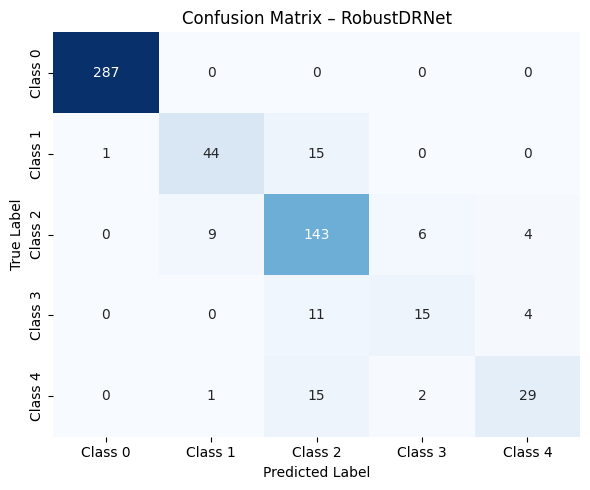

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_meta, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=[f"Class {i}" for i in range(cm.shape[1])],
    yticklabels=[f"Class {i}" for i in range(cm.shape[0])]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – RobustDRNet")
plt.tight_layout()
plt.show()

### Overall Accuracy

In [76]:
accuracy = accuracy_score(y_meta, y_pred)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")

Overall Accuracy: 0.8840 (88.40%)


In [77]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

n_classes = len(np.unique(y_meta))
y_bin = label_binarize(y_meta, classes=list(range(n_classes)))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

### Plot ROC curves

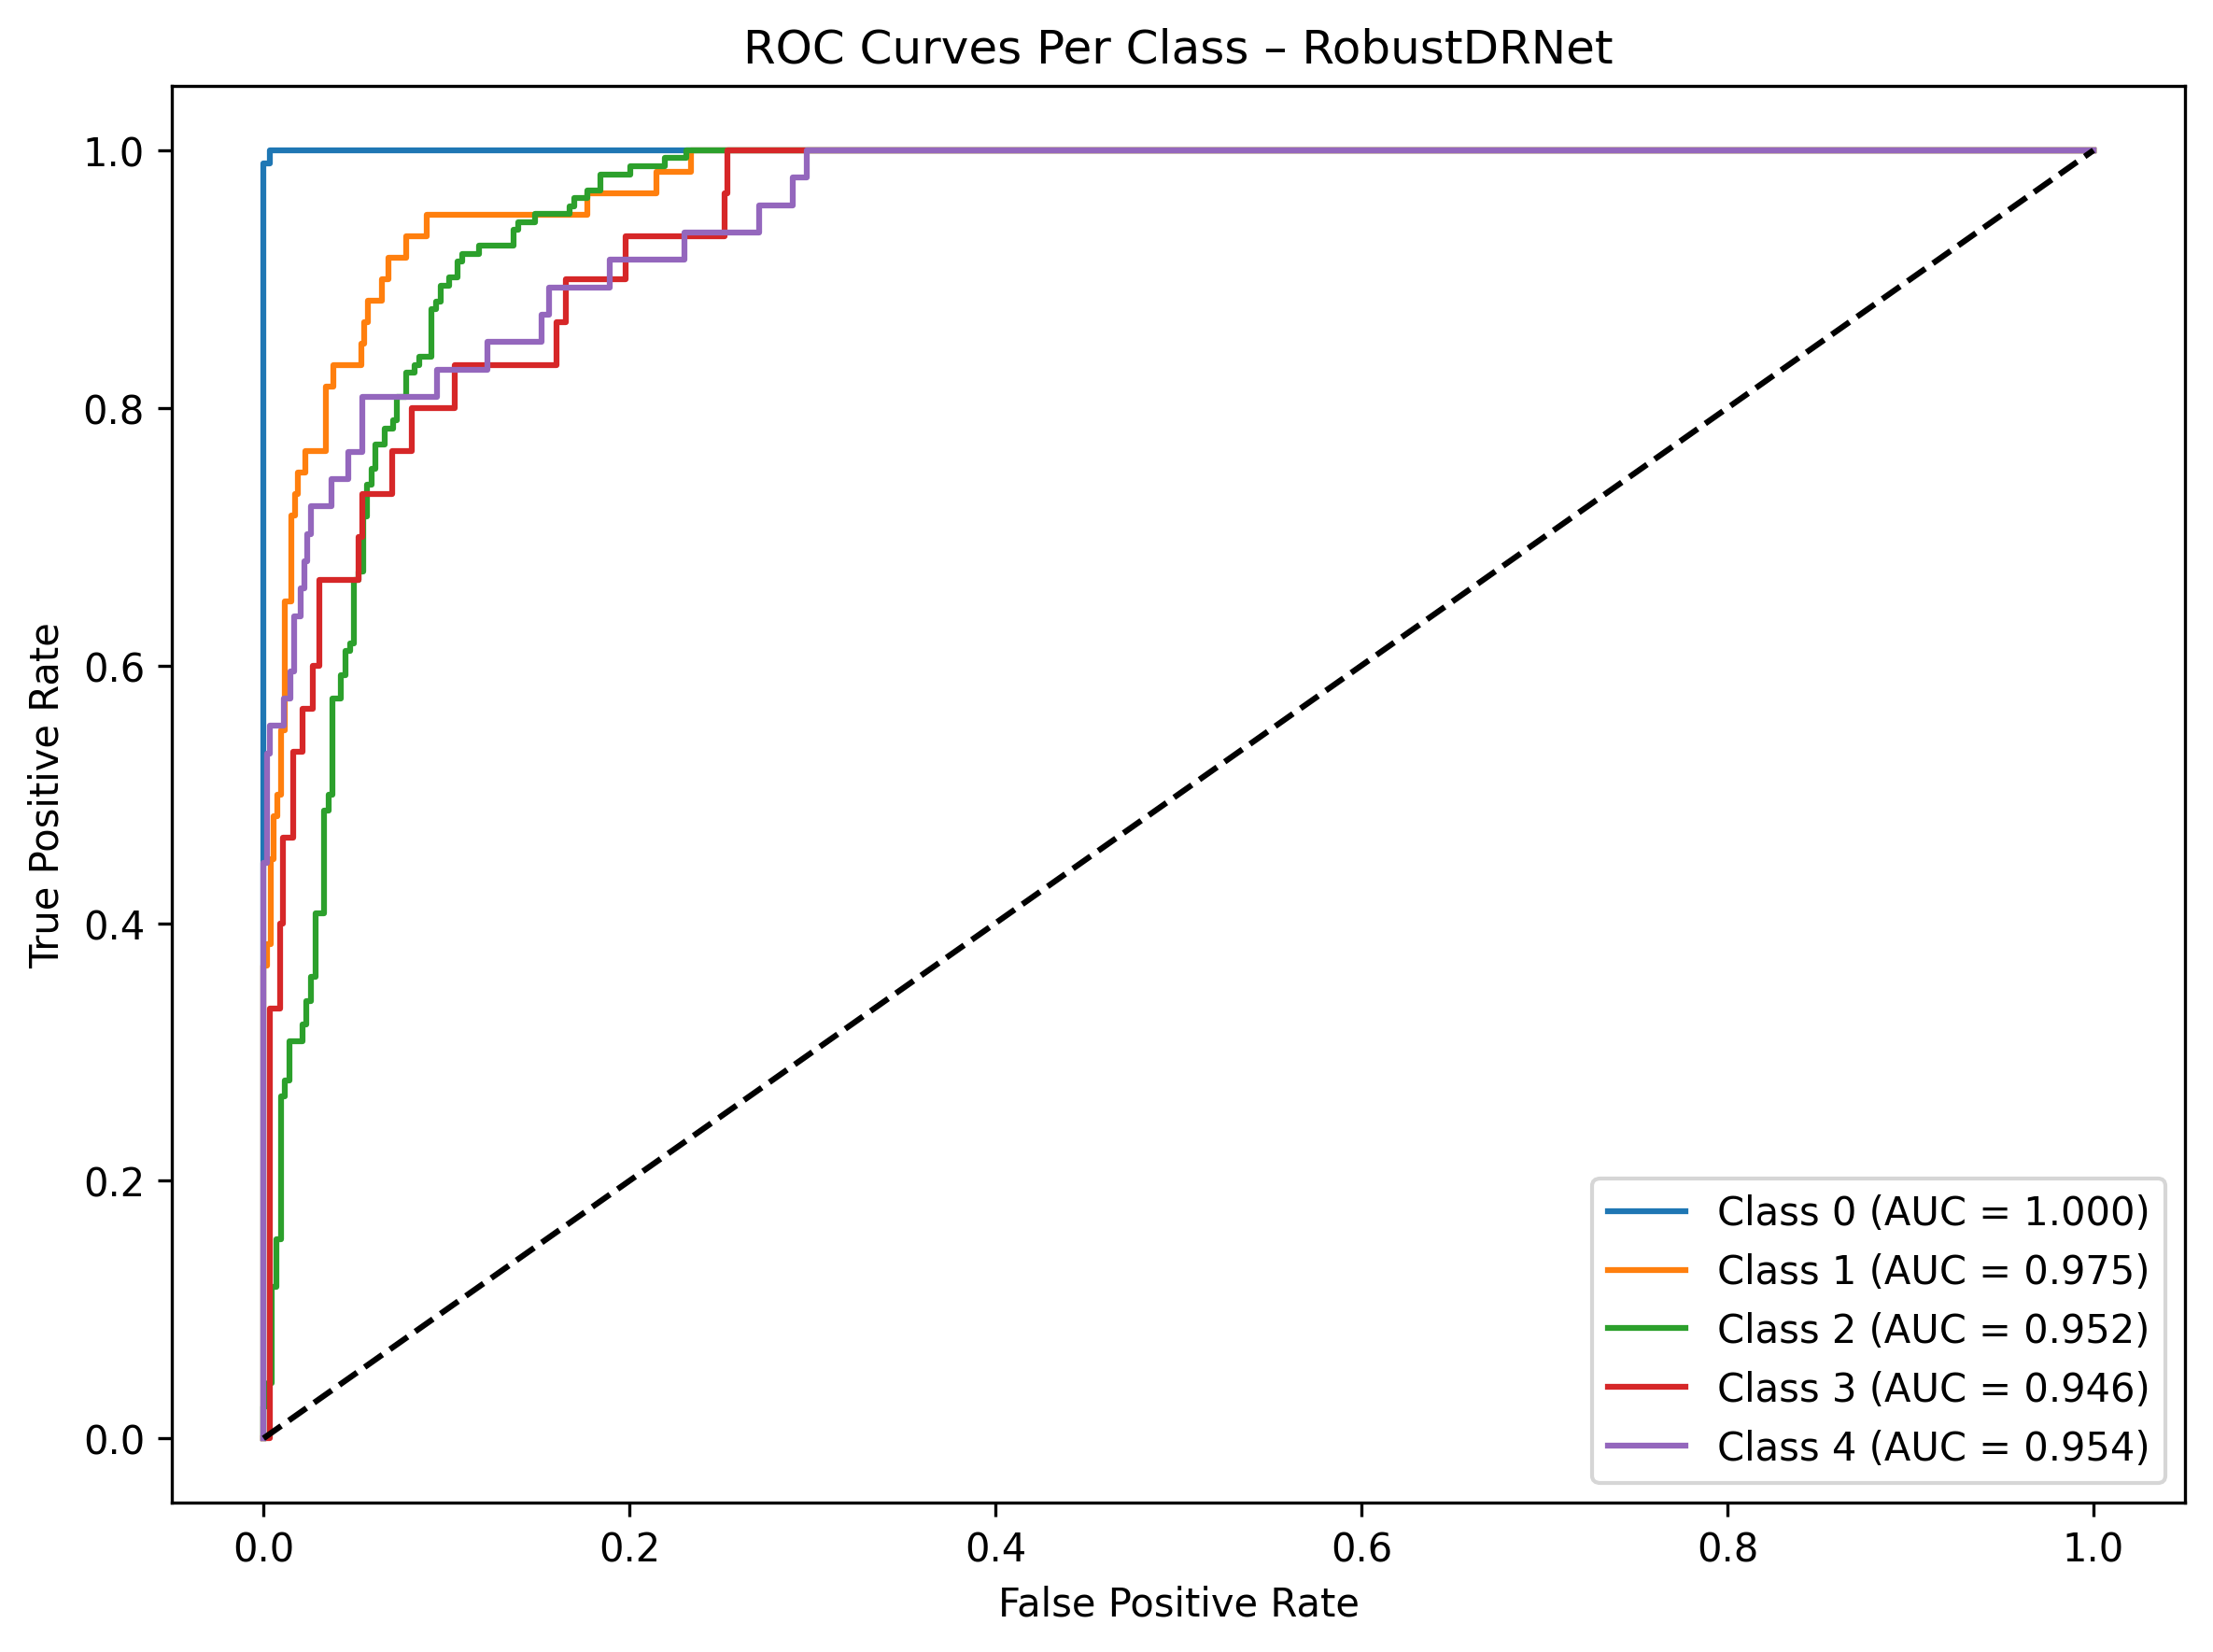

In [78]:
plt.figure(figsize=(8, 6),dpi=300)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Per Class – RobustDRNet")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### Micro-average ROC

In [79]:
fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), y_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

### Macro-average ROC

In [80]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
roc_auc_macro = auc(all_fpr, mean_tpr)

### Plot macro and micro ROC

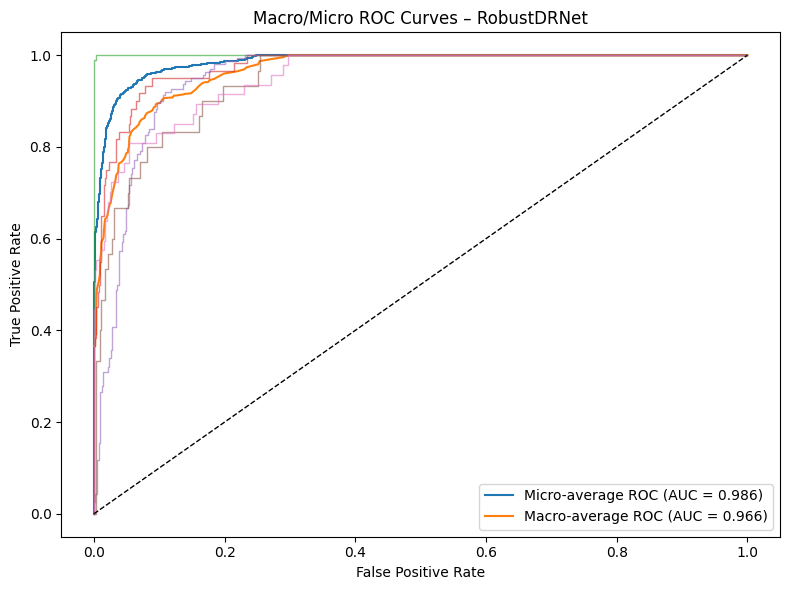

In [81]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f"Micro-average ROC (AUC = {roc_auc_micro:.3f})")
plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {roc_auc_macro:.3f})")

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=1, alpha=0.6)

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro/Micro ROC Curves – RobustDRNet")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### Final per-class metrics report

In [82]:
print("\nClassification Report RobustDRNet:\n")
print(classification_report(y_meta, y_pred))


Classification Report RobustDRNet:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       287
           1       0.81      0.73      0.77        60
           2       0.78      0.88      0.83       162
           3       0.65      0.50      0.57        30
           4       0.78      0.62      0.69        47

    accuracy                           0.88       586
   macro avg       0.80      0.75      0.77       586
weighted avg       0.88      0.88      0.88       586



### Save meta features

In [83]:
np.save("meta_features.npy", X_meta)
np.save("meta_labels.npy", y_meta)

### Predicted vs True labels

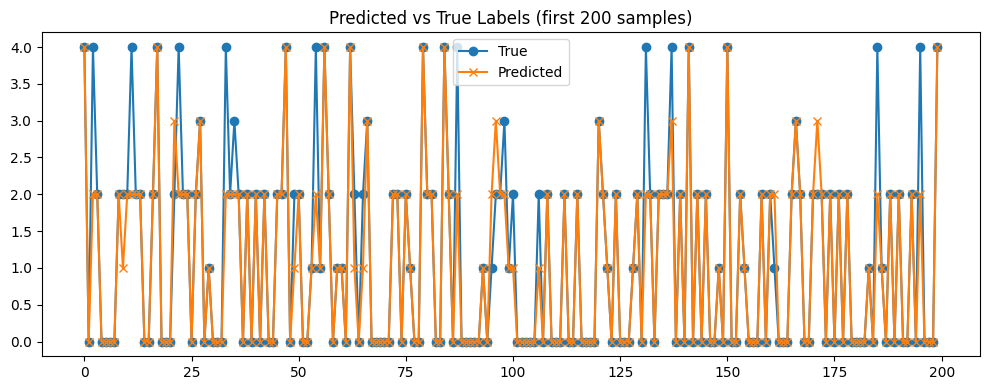

In [84]:
plt.figure(figsize=(10, 4))
plt.plot(y_meta[:200], label="True", marker="o")
plt.plot(y_pred[:200], label="Predicted", marker="x")
plt.title("Predicted vs True Labels (first 200 samples)")
plt.legend()
plt.tight_layout()
plt.show()

### Additional sanity check: Distribution of predictions

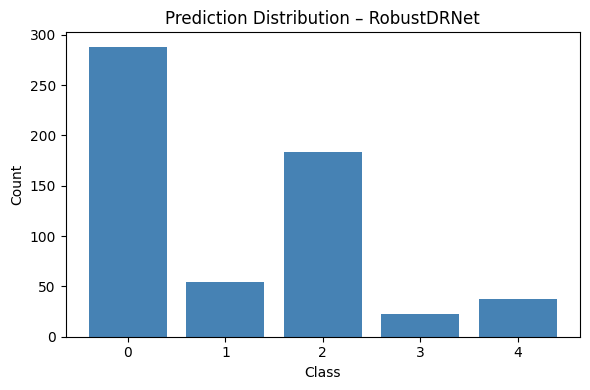

In [85]:
plt.figure(figsize=(6,4))
unique, counts = np.unique(y_pred, return_counts=True)
plt.bar(unique, counts, color="steelblue")
plt.title("Prediction Distribution – RobustDRNet")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [86]:
print("RobustDRNet evaluation complete.")

RobustDRNet evaluation complete.
